### Compare the performance of different methods

In solver.py, we defined 3 methods in the class **SolveODE**, which are `Euler`, `RK4` and `RK45` respectively. The default method are set to be `RK45` since it performs better than other methods.

In this part, we will compare the errors between these three algorithms by comparing with the analytical solutions in simple model and show why the `RK45` is the best method.

In our simple case, we assume that:
- the atmosperic density $\rho _a$ is exponential ($\rho_a = \rho_0 e^{-z/H}$)
- no gravitational acceleration ($g=0$)
- flat planet ($R_p = \infty$)
- no lift ($C_L = 0$)
-  no mass change ($\frac{dm}{dt}=0$)
- no fragmentation ($\sigma_0 = \infty$, $\frac{dr}{dt}=0$)

Then our model can be simplified as:
$$ \left\{
\begin{aligned}
\frac{dv}{dt} & = & \frac{-C_d \rho_a  A}{2m} v^2 \\
\frac{dz}{dt} & = & -v \sin(\theta) \\
\frac{dx}{dt} & = & v \cos(\theta), 
\end{aligned}
\right.
$$
where the is the atmospheric density $\rho_a = \rho_0 e^{-\frac{z}{H}}$, $z_0$ = 100000, $C_d, A, m, \theta$ are constants.

By the first two differential equations, we can find the relationships between velocity **v** and altitude **z**.

Then we have $\frac{dv}{dz}$:
$$\frac{dv}{dz} =  \frac{-C_d \rho_0 e^{-\frac{z}{H}} A}{2m \sin(\theta)} v ,$$
$$\frac{dv}{v} =  \frac{-C_d \rho_0 e^{-\frac{z}{H}} A}{2m \sin(\theta)} dz, $$

Take integral on both sides:
$$\int \frac{dv}{v} = \frac{-C_d \rho_0  A}{2m \sin(\theta)} \int e^{-\frac{z}{H}} dz,$$
$$ \log(v) = -H \frac{-C_d \rho_0  A}{2m \sin(\theta)} \ e^{-\frac{z}{H}}  + C, $$
$$v = \exp({-H \frac{-C_d \rho_0  A}{2m \sin(\theta)} \ e^{-\frac{z}{H}}}) + C' $$

Hence, if we substitute the altitude **z** into the analytical solutions, the accurate velocity can be obtained and we can compare the precise velocities with the results generated by numerical solvers.

The absolute error between precise velocities and estimated velocities shows the performance of algorithms. 

Here are the realizations and comparsions.

In [2]:
from scipy.integrate import solve_ivp
import numpy as np
import pandas as pd
from armageddon import SolveODE, Planet

We set the initial altitude $z_0$ = 100e3, initial velocity $v_0$ = 19e3, initial distance $x_0$ = 0, angle = 45 degrees, density = 3000 $\text{kg/m}^3$, radius of asteriod = 35km. The mass can be calculated by $m = density * \frac{4}{3} \pi r^3$ since it will not change in simple case.

The initstep size of 'Euler' and 'RK4' methods is 0.1;
The maxstep size of 'RK45' is 0.1.

In [3]:
Cd = 1.
H = 8000.
rho0 = 1.2
density = 3000
velocity = 19000
radius = 35
altitude = 100000
mass = (4/3) * np.pi * radius**3 * density
theta = 45*np.pi/180
distance = 0.0
A = np.pi * radius**2

In [4]:
def simple_model(t, y):
    dy = np.zeros_like(y)
    dy[0] = -Cd*A*rho0*0.5*np.exp(-y[1]/H)*y[0]**2/mass
    dy[1] = -y[0]*np.sin(theta)
    dy[2] = y[0]*np.cos(theta)
    return dy

# initial conditions
y0 = [velocity, altitude, distance]
# Euler method
solver_euler = SolveODE(simple_model, (0.0, 50.0), y0, tol=1e-8, method= 'Euler', initstep = 0.5)
solver_euler.solve()
sol1 = solver_euler.sol
vel1 = sol1[:, 0]
z1 = sol1[:, 1]

# RK4 method
solver_RK4 = SolveODE(simple_model, (0.0, 50.0), y0, tol=1e-8, method= 'RK4', initstep = 0.5)
solver_RK4.solve()
sol2 = solver_RK4.sol
vel2 = sol2[:, 0]
z2 = sol2[:, 1]

# RK45 method
solver_RK45 = SolveODE(simple_model, (0.0, 50.0), y0, tol=1e-8, method= 'RK45', maxstep = 0.5)
solver_RK45.solve()
sol3 = solver_RK45.sol
vel3 = sol3[:, 0]
z3 = sol3[:, 1]


In [5]:
# The analytical solution
def analytic_sol(z):
    C = np.log(velocity) + (H * Cd * rho0 * A * np.exp(-altitude/H))/(2 * mass * np.sin(theta))
    lnv = (-1* Cd*rho0*A*H * np.exp(-z/H))/(2*mass * np.sin(theta)) + C
    return np.exp(lnv)

In [6]:
# the real velocity given by altitude z from methods
real_v1 = analytic_sol(z1)
real_v2 = analytic_sol(z2)
real_v3 = analytic_sol(z3)

## Average Errors

In [7]:
print(np.sum(np.abs((real_v1 - vel1)/real_v1))/len(vel1))
print(np.sum(np.abs((real_v2 - vel2))/real_v2)/len(vel2))
print(np.sum(np.abs((real_v3 - vel3)/real_v3))/len(vel3))

0.024380532876107957
3.067841398457763e-05
4.2824718316092555e-07


Clearly, RK45 ensures relatively low errors over the inegration interval. 

## Error vs Tolerance

In [8]:
tolerances = [10**(-i) for i in range(1, 16, 1)]
averageRelativeError = []

for t in tolerances:
    solver_RK45 = SolveODE(simple_model, (0.0, 50.0), y0, tol=t, method= 'RK45', maxstep = 0.5)
    solver_RK45.solve()
    sol3 = solver_RK45.sol
    vel3 = sol3[:, 0]
    z3 = sol3[:, 1]
    real_v3 = analytic_sol(z3)
    averageRelativeError.append(np.sum(np.abs((real_v3 - vel3)/real_v3))/len(vel3))


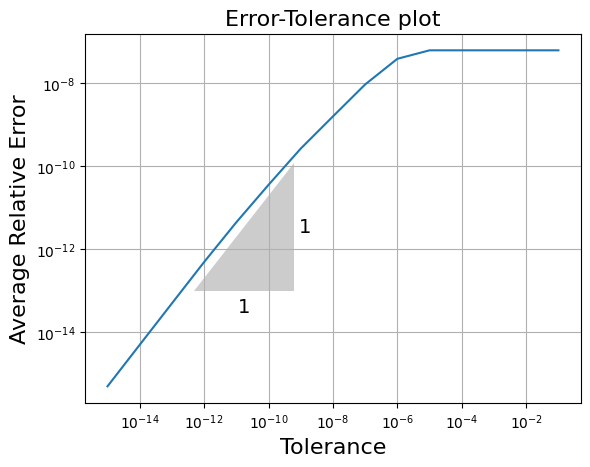

In [12]:
import matplotlib.pyplot as plt
from mpltools import annotation
%matplotlib inline

tols = np.array(tolerances)
errs = np.array(averageRelativeError)
fig = plt.figure()
ax = fig.add_subplot()
ax.loglog(tols, errs)
annotation.slope_marker((5e-13, 1e-13), (1, 1), ax=ax,
                        size_frac=0.2, pad_frac=0.05, text_kwargs = dict(fontsize = 14))
ax.set_xlabel('Tolerance', fontsize=16)
ax.set_ylabel('Average Relative Error', fontsize=16)
ax.set_title('Error-Tolerance plot', fontsize=16)
ax.grid(True)

In [10]:
Cd = 1.
Cd = 1.
Ch = 0.1
Q = 1e7
Cl = 1e-3
alpha = 0.3
Rp = 6371e3
g = 9.81
H = 8000
rho0 = 1.2

radius = 9.75
velocity = 19e3
density = 3300.
strength = 2e6,
angle = 20.
init_altitude = 100e3
mass = 4*np.pi*radius**3/3


def rho(x):
    return rho0*np.exp(-x/H)


def pallas_rhs(t, y):

    """ Fuction to return the RHS of the asteroid equations
        Paramters
        ---------
        t : scalar time
            Current time during integration

        y : np.array
            Statevector array

        Note
        ----
        y[0] = v        Velocity of the asteroid
        y[1] = m        Mass of the asteroid
        y[2] = theta    Angle in the entry plane
        y[3] = z        Altitude
        y[4] = x        Range
        y[5] = r        Radius of the asteroid
    """

    dy = np.zeros_like(y)

    rhoa = rho(y[3])
    A = np.pi*y[5]**2

    dy[0] = -0.5*Cd*rhoa*A*y[0]**2/y[1] + g*np.sin(y[2])
    dy[1] = -0.5*Ch*rhoa*A*y[0]**3/Q
    dy[2] = g*np.cos(y[2])/y[0] -\
        0.5*Cl*rhoa*A*y[0]/y[1] - y[0]*np.cos(y[2])/(Rp+y[3])
    dy[3] = -y[0]*np.sin(y[2])
    dy[4] = y[0]*np.cos(y[2])/(1 + y[3]/Rp)

    Yt = rhoa*y[0]**2

    if Yt <= strength:
        dy[5] = 0.0
    else:
        dy[5] = np.sqrt(3.5*alpha*rhoa/density)*y[0]

    return dy


tolerances = [10**(-i) for i in range(1, 16, 1)]

averageRelativeError = []

y0 = [velocity, mass, angle*np.pi/180, init_altitude, 0.0, radius]

for t in tolerances:
    solver_RK45 = SolveODE(pallas_rhs, (0.0, 50.0), y0, tol=t,
                           method='RK45', maxstep=0.5)
    solver_RK45.solve()
    averageRelativeError.append(np.sum(solver_RK45.err)/len(solver_RK45.err))

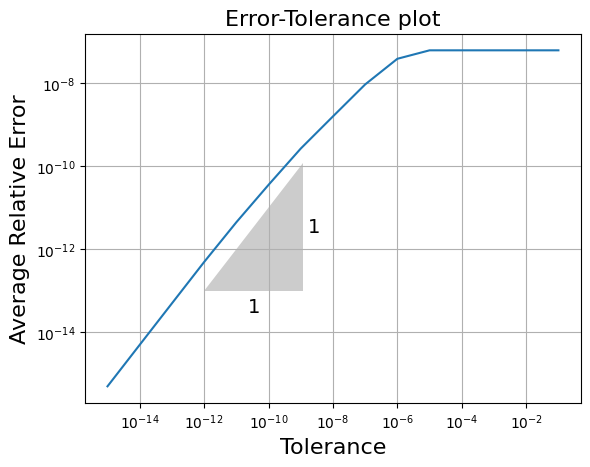

In [13]:
import matplotlib.pyplot as plt
from mpltools import annotation
%matplotlib inline

tols = np.array(tolerances)
errs = np.array(averageRelativeError)
fig = plt.figure()
ax = fig.add_subplot()
ax.loglog(tols, errs)
annotation.slope_marker((1e-12, 1e-13), (1, 1), ax=ax,
                        size_frac=0.2, pad_frac=0.05, text_kwargs = dict(fontsize = 14))
ax.set_xlabel('Tolerance', fontsize=16)
ax.set_ylabel('Average Relative Error', fontsize=16)
ax.set_title('Error-Tolerance plot', fontsize=16)
ax.grid(True)